In [1]:
import h5py
import re
from tqdm import tqdm

def get_attribute_names(fold_ptr, fold):
    attributes_fold = list(fold_ptr.attrs.keys())
    gt_fold = [x for x in attributes_fold if x.startswith('gt')]
    preds_fold = [x for x in attributes_fold if x.startswith('preds')]
    gt_fold = sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))
    preds_fold = sorted(preds_fold, key=lambda x: 
                        (50 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    return gt_fold, preds_fold

def process_hdf5(filename, number_folds=10, nreps=50):
    f = h5py.File(filename, 'r')
    fold_gt, fold_preds, fold_ppv, fold_sens = [], [], [], []
    for fold in range(number_folds):
        fold_data = f[f'fold{fold}/data/']
        gts, preds = get_attribute_names(fold_data, fold)
        obs_gt, obs_preds, obs_ppv, obs_sens = [], [], [], []
        for idx, gt_name in tqdm(enumerate(gts)):
            start = idx * nreps
            predictions, ft_ppv, ft_sens = [], [], []
            gt = fold_data.attrs[gt_name]
            obs_gt.append(gt)
            for i in range(nreps):
                pred = fold_data.attrs[preds[start + i]]
                predictions.append(pred)
                ppv_, sensitivity_ = schmidt_metrics(gt, pred)
                ft_ppv.append(ppv_)
                ft_sens.append(sensitivity_)
            obs_preds.append(predictions)
            obs_ppv.append(ft_ppv)
            obs_sens.append(ft_sens)
        fold_ppv.append(obs_ppv)
        fold_preds.append(obs_preds)
        fold_sens.append(obs_sens)
        fold_gt.append(obs_gt)
    return fold_gt, fold_preds, fold_ppv, fold_sens

In [2]:
!pwd
import os
os.chdir('/Users/miguelmartins/Projects/hybrid-hmm')
!pwd
import matplotlib as mpl

import matplotlib.pyplot as plt
# mpl.rcParams.update(mpl.rcParamsDefault)


# Else use texparams
SMALL_SIZE = 22
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 
plt.rc('axes', labelsize=SMALL_SIZE)# fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)    
plt.rcParams.update({
   "text.usetex": True,
    "font.family": "Helvetica"
 })


import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from utility_functions.metrics import schmidt_metrics

import scipy.stats as stats
import itertools
from typing import Dict, List


/Users/miguelmartins/Projects/hybrid-hmm/notebooks
/Users/miguelmartins/Projects/hybrid-hmm


In [3]:
# Fine-tune 

directory = 'results/rerun/hybrid/fine_tune/results(1).hdf5'
f = h5py.File(directory, 'r')
gt, preds, ppv, sens = process_hdf5(directory)
gt, preds, ppv, sens = np.array(gt, dtype=object), np.array(preds,dtype=object), np.array(ppv,dtype=object), np.array(sens,dtype=object) 
ppv, sens = np.array(ppv), np.array(sens) 
# plt.savefig(f'{metric_name}.png', dpi=1200, bbox_inches='tight',)

327it [00:10, 30.53it/s]
327it [00:09, 33.28it/s]
327it [00:10, 31.68it/s]
327it [00:10, 30.42it/s]
327it [00:07, 44.69it/s]
327it [00:06, 49.53it/s]
327it [00:06, 48.98it/s]
327it [00:07, 45.48it/s]
327it [00:08, 39.42it/s]
327it [00:07, 42.37it/s]


In [57]:
import matplotlib.cm as cm

def plot_violins(results, results2, num_epochs=50):
    plt.rcParams["figure.figsize"] = (20,12)
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=SMALL_SIZE)# fontsize of the tick labels
    plt.rc('legend', fontsize=10)
    plt.rc('font', size=SMALL_SIZE)
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
        })
    y = np.mean(np.mean(results, axis=1).astype(np.float32), axis=0)
    y_error = np.std(np.mean(results, axis=1).astype(np.float32), axis=0)
    
    y_2 = np.mean(np.mean(results2, axis=1).astype(np.float32), axis=0)
    y_error_2 = np.std(np.mean(results2, axis=1).astype(np.float32), axis=0)
    print(y.shape, y_error.shape)
    x = [i for i in range(num_epochs)]
    
    plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    #plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=2)
    plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
    #plt.subplot(3, 1, 1) 
    fig = plot1.boxplot(fold_ppv[:, :20], patch_artist=True)
    #t11 = [''] + [f'{i}' for i in range(20)]
    #plot1.set_xlim(0, 10)
    #fig.ylim(0, 10)
    #plot1.set_ylim(np.min(np.median(fold_ppv, axis=1)), np.max(np.median(fold_ppv, axis=1)), 10)
   

    

    #plot1.set_xticks(range(len(t11)), t11, size='medium')
    # Fill with colors
    cmap = cm.ScalarMappable(cmap='Greys')
    #print(dir(plot1.axes['boxes']))
    test_mean = np.median(fold_ppv[:, :20].astype(np.float32),axis=0)
    for patch, color in zip(fig['boxes'], cmap.to_rgba(test_mean)):
        patch.set_facecolor(color)
    #plt.subplot(3, 1, 2) 
    
    fig2 = plot2.boxplot(fold_sens[:, :20].astype(np.float32), patch_artist=True)
    
    cmap = cm.ScalarMappable(cmap='Greys')
    #print(dir(plot1.axes['boxes']))
    test_mean = np.median(fold_sens[:, :20].astype(np.float32),axis=0)
    for patch, color in zip(fig2['boxes'], cmap.to_rgba(test_mean)):
        patch.set_facecolor(color)
    
    #plt.subplot(3, 1, 3)
    plot1.set_xticks(np.arange(1, 21), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
    plot2.set_xticks(np.arange(1, 21), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
    
    plot1.axvline(x = 1.5, color = 'green', linestyle='dashed')
    plot1.axvline(x = 11.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
    plot1.axvline(x = 13.5, color = 'red', linestyle='dashed', label=r'$(-)$ Statistically different')
    plot1.axvline(x = 43.5, color = 'red', alpha=0.2)
    plot2.axvline(x = 2.5, color = 'red', linestyle='dashed',label=r'$(-)$ Statistically different') # make line invisible
    
    
    plot1.set_xlim(0, 21)
    plot1.axvspan(0., 1.5, facecolor='gray', alpha=.2)
    plot1.axvspan(1.5, 11.5, facecolor='green', alpha=.2)
    plot1.axvspan(11.5, 13.5, facecolor='gray', alpha=.2)
    plot1.axvspan(13.5, 21, facecolor='red', alpha=.2)
    plot2.set_xlim(0, 21)
    plot2.axvspan(0.0, 2.5, facecolor='gray', alpha=.2)
    plot2.axvspan(2.5, 21, facecolor='red', alpha=.2) 
    #plot1.set_xlabel(r'$\mathbf{\Psi}_{k}$' + r' after $k$ epochs')
    #plot2.set_xlabel(r'$\mathbf{\Psi}_{k}$'+ r' after $k$ epochs')
    plot1.set_ylabel(r'Positive Predictive Value')
    plot2.set_ylabel(r'Sensitivity')

    plot1.legend(shadow=True)
    plot2.legend(shadow=True)
    plt.tight_layout()
    plt.plot()
    plt.savefig('fine_tune_final.png', dpi=600, bbox_inches='tight')

fold_ppv, fold_sens = np.mean(ppv, axis=1), np.mean(sens, axis=1)
plot_violins(ppv, sens, 50)

(50,) (50,)


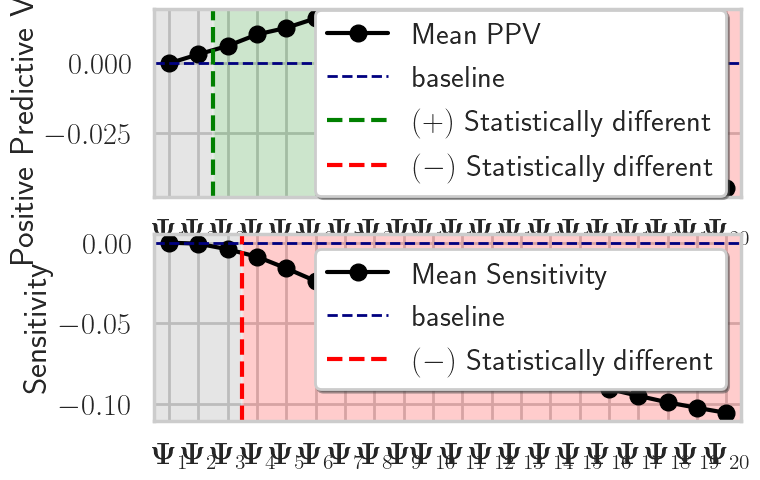

In [78]:
fold_ppv, fold_sens = np.mean(ppv, axis=1).astype(np.float32), np.mean(sens, axis=1).astype(np.float32)
#shift_arr = np.roll(fold_ppv[:, :-1], shift=1, axis=1)
#shift_arr = np.concatenate( [np.array([[0] * 10]).T, shift_arr], axis=1)
#diff_support = np.ones_like(fold_ppv) * fold_ppv[:, 0].shape 
plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    #plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=2)
plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
plot1.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
plot2.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])


#plot1.set_xlabel(r'$\mathbf{\Psi}_{k}$' + r' after $k$ epochs')
#plot2.set_xlabel(r'$\mathbf{\Psi}_{k}$'+ r' after $k$ epochs')
plot1.set_ylabel(r'Positive Predictive Value')
plot2.set_ylabel(r'Sensitivity')

plot1.plot(np.mean(fold_ppv -  fold_ppv[:, 0].reshape(10, 1), axis=0)[:20], marker='o', color='black', label='Mean PPV')
plot2.plot(np.mean(fold_sens -  fold_sens[:, 0].reshape(10, 1), axis=0)[:20], marker='o', color='black', label='Mean Sensitivity')
plot1.axhline(y=0, linewidth=2, color='navy', linestyle='--', label='baseline')
plot2.axhline(y=0, linewidth=2, color='navy', linestyle='--', label='baseline')
plot1.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
plot2.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])

plot1.axvline(x = 1.5, color = 'green', linestyle='dashed')
plot1.axvline(x = 11.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
plot1.axvline(x = 13.5, color = 'red', linestyle='dashed', label=r'$(-)$ Statistically different')
plot1.axvline(x = 43.5, color = 'red', alpha=0.2)
plot2.axvline(x = 2.5, color = 'red', linestyle='dashed',label=r'$(-)$ Statistically different') # make line invisible


plot1.set_xlim(-.5, 19.5)
plot1.axvspan(-.5, 1.5, facecolor='gray', alpha=.2)
plot1.axvspan(1.5, 11.5, facecolor='green', alpha=.2)
plot1.axvspan(11.5, 13.5, facecolor='gray', alpha=.2)
plot1.axvspan(13.5, 21, facecolor='red', alpha=.2)
plot2.set_xlim(-.5, 19.5)
plot2.axvspan(-0.5, 2.5, facecolor='gray', alpha=.2)
plot2.axvspan(2.5, 21, facecolor='red', alpha=.2) 

plot1.legend(shadow=True, loc='center right')
plot2.legend(shadow=True)

#plt.tight_layout()
plt.show()
#plt.savefig('fine_tune_rel_ph16_to_circor.png', dpi=600, bbox_inches='tight')

In [6]:
# Fine-tune 

directory = 'results/rerun/ph16/finetune_1_50_hmm_only_circor_to_ph16/2023-06-12_10_38_39/results.hdf5'
f = h5py.File(directory, 'r')
p_gt, p_preds, p_ppv, p_sens = process_hdf5(directory)
p_gt, p_preds, p_ppv, p_sens = np.array(p_gt, dtype=object), np.array(p_preds,dtype=object), np.array(p_ppv,dtype=object), np.array(p_sens,dtype=object) 

fold_ppv, fold_sens = np.mean(p_ppv, axis=1), np.mean(p_sens, axis=1)

74it [00:01, 47.97it/s]
74it [00:01, 46.06it/s] 
74it [00:01, 38.86it/s]
74it [00:01, 42.33it/s]
74it [00:01, 41.61it/s]
74it [00:01, 50.12it/s]
74it [00:01, 38.47it/s]
74it [00:01, 38.62it/s]
74it [00:01, 37.03it/s]
74it [00:01, 38.64it/s]


In [60]:
def plot_violins(results, results2, num_epochs=50):
    plt.rcParams["figure.figsize"] = (20,12)
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=SMALL_SIZE)# fontsize of the tick labels
    plt.rc('legend', fontsize=10)
    plt.rc('font', size=SMALL_SIZE)
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
        })
    y = np.mean(np.mean(results, axis=1).astype(np.float32), axis=0)
    y_error = np.std(np.mean(results, axis=1).astype(np.float32), axis=0)
    
    y_2 = np.mean(np.mean(results2, axis=1).astype(np.float32), axis=0)
    y_error_2 = np.std(np.mean(results2, axis=1).astype(np.float32), axis=0)
    print(y.shape, y_error.shape)
    x = [i for i in range(num_epochs)]
    
    plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    #plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=2)
    plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
    #plt.subplot(3, 1, 1) 
    fig = plot1.boxplot(fold_ppv[:, :20], patch_artist=True)
    #t11 = [''] + [f'{i}' for i in range(20)]
    #plot1.set_xlim(0, 10)
    #fig.ylim(0, 10)
    #plot1.set_ylim(np.min(np.median(fold_ppv, axis=1)), np.max(np.median(fold_ppv, axis=1)), 10)
   

    

    #plot1.set_xticks(range(len(t11)), t11, size='medium')
    # Fill with colors
    cmap = cm.ScalarMappable(cmap='Greys')
    #print(dir(plot1.axes['boxes']))
    test_mean = np.median(fold_ppv[:, :20].astype(np.float32),axis=0)
    for patch, color in zip(fig['boxes'], cmap.to_rgba(test_mean)):
        patch.set_facecolor(color)
    #plt.subplot(3, 1, 2) 
    
    fig2 = plot2.boxplot(fold_sens[:, :20].astype(np.float32), patch_artist=True)
    
    cmap = cm.ScalarMappable(cmap='Greys')
    #print(dir(plot1.axes['boxes']))
    test_mean = np.median(fold_sens[:, :20].astype(np.float32),axis=0)
    for patch, color in zip(fig2['boxes'], cmap.to_rgba(test_mean)):
        patch.set_facecolor(color)
    
    #plt.subplot(3, 1, 3)
    plot1.set_xticks(np.arange(1, 21), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
    plot2.set_xticks(np.arange(1, 21), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
    
    plot1.axvline(x = 1.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
    #plot1.axvline(x = 11.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
    #plot1.axvline(x = 13.5, color = 'red', linestyle='dashed', label=r'$(-)$ Statistically different')
    #plot1.axvline(x = 43.5, color = 'red', alpha=0.2)
    
    plot2.axvline(x = 2.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different') # make line invisible
    plot2.axvline(x = 11.5, color = 'green', linestyle='dashed')
    
    plot1.set_xlim(0, 21)
    plot1.axvspan(0., 1.5, facecolor='gray', alpha=.2)
    plot1.axvspan(1.5, 21, facecolor='green', alpha=.2)
    #plot1.axvspan(11.5, 13.5, facecolor='gray', alpha=.2)
    #plot1.axvspan(13.5, 21, facecolor='red', alpha=.2)
    #plot2.set_xlim(0, 21)
    
    plot2.axvspan(0.0, 2.5, facecolor='gray', alpha=.2)
    plot2.axvspan(2.5, 11.5, facecolor='green', alpha=.2)
    plot2.axvspan(11.5, 21, facecolor='gray', alpha=.2)
    
    #plot1.set_xlabel(r'$\mathbf{\Psi}_{k}$' + r' after $k$ epochs')
    #plot2.set_xlabel(r'$\mathbf{\Psi}_{k}$'+ r' after $k$ epochs')
    plot1.set_ylabel(r'Positive Predictive Value')
    plot2.set_ylabel(r'Sensitivity')

    plot1.legend(shadow=True)
    plot2.legend(shadow=True)
    plt.tight_layout()
    plt.plot()
    plt.savefig('plot_fine_tune_circor_to_ph16.png', dpi=600, bbox_inches='tight')

fold_ppv, fold_sens = np.mean(p_ppv, axis=1), np.mean(p_sens, axis=1)
plot_violins(ppv, sens, 50)

/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_33002/3517189325.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_33002/3517189325.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)


(50,) (50,)


In [61]:

#shift_arr = np.roll(fold_ppv[:, :-1], shift=1, axis=1)
#shift_arr = np.concatenate( [np.array([[0] * 10]).T, shift_arr], axis=1)
#diff_support = np.ones_like(fold_ppv) * fold_ppv[:, 0].shape 
plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    #plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=2)
plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
plot1.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
plot2.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])


#plot1.set_xlabel(r'$\mathbf{\Psi}_{k}$' + r' after $k$ epochs')
#plot2.set_xlabel(r'$\mathbf{\Psi}_{k}$'+ r' after $k$ epochs')
plot1.set_ylabel(r'Positive Predictive Value')
plot2.set_ylabel(r'Sensitivity')

plot1.plot(np.mean(fold_ppv -  fold_ppv[:, 0].reshape(10, 1), axis=0)[:20], marker='o', color='black', label='Mean PPV')
plot2.plot(np.mean(fold_sens -  fold_sens[:, 0].reshape(10, 1), axis=0)[:20], marker='o', color='black', label='Mean Sensitivity')
plot1.axhline(y=0, linewidth=2, color='navy', linestyle='--', label='baseline')
plot2.axhline(y=0, linewidth=2, color='navy', linestyle='--', label='baseline')
plot1.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
plot2.set_xticks(np.arange(0, 20), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])

plot1.axvline(x = .5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
#plot1.axvline(x = 11.5, color = 'green', linestyle='dashed')
#plot1.axvline(x = 13.5, color = 'red', linestyle='dashed', label=r'$(-)$ Statistically different')
#plot1.axvline(x = 43.5, color = 'red', alpha=0.2)
#plot2.axvline(x = 2.5, color = 'red', linestyle='dashed',label=r'$(-)$ Statistically different') # make line invisible


plot1.set_xlim(-.5, 19.5)

plot1.axvspan(-.5, .5, facecolor='gray', alpha=.2)
plot1.axvspan(.5, 19.5, facecolor='green', alpha=.2)
#plot1.axvspan(11.5, 13.5, facecolor='gray', alpha=.2)
#plot1.axvspan(13.5, 21, facecolor='red', alpha=.2)
plot2.axvline(x = 1.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
plot2.axvline(x = 10.5, color = 'green', linestyle='dashed')
plot2.set_xlim(-.5, 19.5)
plot2.axvspan(-0.5, 1.5, facecolor='gray', alpha=.2)
plot2.axvspan(1.5, 10.5, facecolor='green', alpha=.2) 
plot2.axvspan(10.5, 19.5, facecolor='gray', alpha=.2)
plot1.legend(shadow=True, loc='center right')
plot2.legend(shadow=True)

#plt.tight_layout()
plt.show()
#plt.savefig('fine_tune_rel_ph16_to_circor.png', dpi=600, bbox_inches='tight')

/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_33002/382100902.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_33002/382100902.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)


[]

In [5]:
fold_ppv, fold_sens = np.mean(p_ppv, axis=1), np.mean(p_sens, axis=1)
def compute_pair_test(baseline, models, alpha=0.05):
    print(baseline, models[:,2])
    
    paired_t_tests = [stats.wilcoxon(baseline, models[:, i], zero_method="zsplit") for i in range(0, models.shape[1])]
    return [(1, i+1) if (p_v:= pair.pvalue) <= alpha else (0,i+1) for i, pair in enumerate(paired_t_tests)]


baseline_ppv  = fold_ppv[:, 0]
baseline_sens = fold_sens[:, 0]
def schmidt_fold(gt, _h_vit):
    n_folds = gt.shape[0]
    mean_fold_ppv = []
    mean_fold_sensitivity = []
    for fold in range(n_folds):
        n_sounds = gt[fold].shape[0]
        ppv, sensitivity = [], []
        for sound in range(n_sounds):
            ppv_, sensitivity_ = schmidt_metrics(gt[fold][sound], _h_vit[fold][sound])
            ppv.append(ppv_)
            sensitivity.append(sensitivity_)
        mean_fold_ppv.append(np.mean(ppv))
        mean_fold_sensitivity.append(np.mean(sensitivity))

    return mean_fold_ppv, mean_fold_sensitivitycompute_pair_test(baseline_sens, fold_sens), compute_pair_test(baseline_ppv, fold_ppv),

NameError: name 'p_ppv' is not defined

In [7]:
def schmidt_fold(gt, _h_vit):
    n_folds = gt.shape[0]
    mean_fold_ppv = []
    mean_fold_sensitivity = []
    for fold in range(n_folds):
        n_sounds = gt[fold].shape[0]
        ppv, sensitivity = [], []
        for sound in range(n_sounds):
            ppv_, sensitivity_ = schmidt_metrics(gt[fold][sound], _h_vit[fold][sound])
            ppv.append(ppv_)
            sensitivity.append(sensitivity_)
        mean_fold_ppv.append(np.mean(ppv))
        mean_fold_sensitivity.append(np.mean(sensitivity))

    return mean_fold_ppv, mean_fold_sensitivity

def read_results(path: str):
    gt = sio.loadmat(path + '/ground_truth.mat', squeeze_me=True)['ground_truth']
    cnn = sio.loadmat(path + '/out_seq.mat', squeeze_me=True)['out_seq']
    vit = sio.loadmat(path + '/viterbi.mat', squeeze_me=True)['viterbi']
    return gt, cnn, vit

def get_accuracy(gt, cnn, n_folds=10):
    acc_folds = []
    for fold in range(n_folds):
        accuracy = []
        for sound in range(len(gt[fold])):
            try:
                accuracy.append(accuracy_score(gt[fold][sound], cnn[fold][sound]))
            except:
                print("fold", fold, "sound", sound, " ", gt[fold][sound].shape, cnn[fold][sound].shape)
                pass
        acc_folds.append(np.mean(accuracy))
    return acc_folds


def metrics_model(path: str):
    gt, cnn, vit = read_results(path)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

def m(path1, path2):
    vit = sio.loadmat(path1, squeeze_me=True)['preds_fold']
    vit -= 1
    gt, _, _ = read_results(path2)
    print(gt.shape, gt[-1].shape)
    print(vit.shape)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

ph16_path = 'results/matlab/preds_ph16_folds.mat'
ph16_path_2 = 'results/unet/unet/2022-02-26_07_49_39'
ph16_hsmm = m(ph16_path, ph16_path_2)
hsmm_path = 'results/matlab/preds_circor_folds.mat'
path_2 = 'results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18'
circor_hsmm = m(hsmm_path, path_2)

ph16_crosse_unet_env = metrics_model('results/unet/unet/2022-02-26_07_49_39')
ph16_fernando_CE_mfcc = metrics_model('results/rerun/fernando/fernando_CE_physio16_mfcc_joint/2022-09-17_07_52_13/')
ph16_hmm_nnonly_mmi_env = metrics_model('results/rerun/hybrid/hmm_nnonly_mmi_env_physio16/2022-09-17_10_08_14')
ph16_hmm_hybrid_mmi_env = metrics_model('results/rerun/hybrid/hmm_hybrid_mmi_env_physio16/2022-09-16_15_46_30')
ph16_hmm_nnonly_cl_env = metrics_model('results/rerun/hybrid/hmm_nnonly_cl_env_physio16/2022-09-18_09_38_31')
ph_16_hmm_hybird_cl_env = metrics_model('results/rerun/hybrid/hmm_hybrid_cl_env_physio16/2022-09-19_10_57_50')
ph_16_hmm_nnonly_cl_mfcc = metrics_model('results/rerun/hybrid/mfcc/2022-09-20_08_01_55')
ph_16_hmm_nnonly_cl_psd = metrics_model('results/rerun/hybrid/psd/hmm_nnonly_cl_psd_ph16/2022-09-26_11_51_19')



circor_hybrid_cle_env = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18')
circor_unet_cre_env = metrics_model('results/unet/circor/unet/2022-06-20_10_40_26')
circor_hybrid_1epoch = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-19_17:09:36')
# v não é nn only. é nn + HMM com SGD com learning rate 1e-4
circor_hybrid_env_cl_nn_only = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-22_18:36:22')
circor_nn_only_env_cl = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_nnonly/2022-07-31_16:50:27')

circor_nn_only_env_mmi_1e4 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e4/2022-08-22_13:56:23')
circor_nn_only_env_mmi_1e3 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09')

circor_fernando = metrics_model('results/fernando/circor/fernando_CE_physio16_mfcc_joint/2022-09-16_15_46_30')
_, circor_hsmm_ppv, circor_hsmm_sens = circor_hsmm
_, ph16_hsmm_ppv, ph16_hsmm_sens = ph16_hsmm

(10,) (78,)
(10, 78)
(10,) (327,)
(10, 327)


In [121]:
def generate_boxplot_df(metric, *args, **kwargs):
    #assert len(args) == len(kwargs)
    
    model_row = []
    values_row = []
    metric_row = []
    names = kwargs['names']
    for i in range(len(args)):
        values_row.append(np.array(args[i]))
        model_row.append(np.array([names[i]] * len(args[i])))
        metric_row.append(np.array([metric] * len(args[i])))
    model = np.concatenate([*model_row])
    values = np.concatenate([*values_row])
    metric = np.concatenate([*metric_row])
    
    return pd.DataFrame({'model': model, 'values': values, 'metric': metric})


names = ['$\mathbf{HSMM}$',
         '$\mathbf{U}$-$\mathbf{Net}$',
         '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$']

df_circor_ppv = generate_boxplot_df('$\mathrm{\mathbf{PPV}}$', circor_hsmm_ppv, circor_unet_cre_env[1], circor_fernando[1], circor_nn_only_env_cl[1], names=names)
df_circor_sens = generate_boxplot_df('$\mathrm{\mathbf{S}}$', circor_hsmm_sens, circor_unet_cre_env[2], circor_fernando[2], circor_nn_only_env_cl[2], names=names)
df_circor = pd.concat([df_circor_sens, df_circor_ppv], axis=0)

/var/folders/cr/qd8xdw991dv9ypjzzwsktpqc0000gn/T/ipykernel_34569/2783698379.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


-0.8 1.8 0.7165818103689588 0.9734314848242923


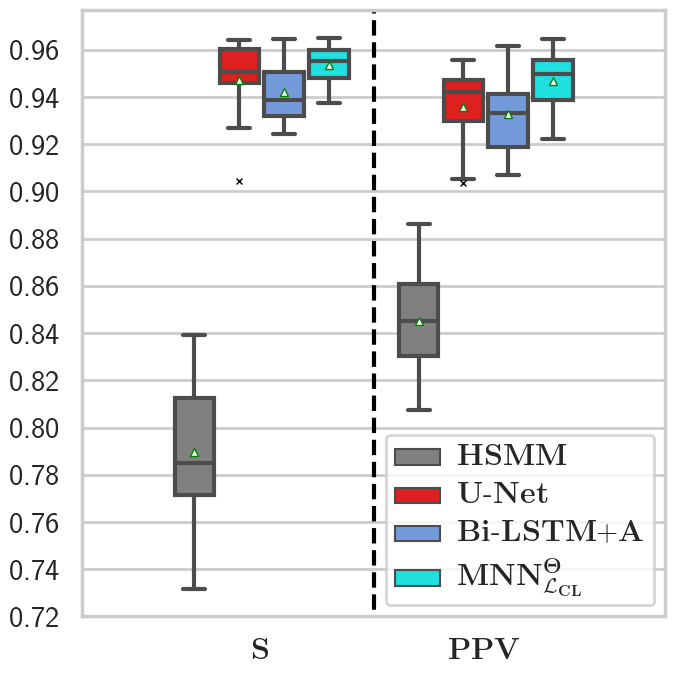

In [123]:
import seaborn as sns
import matplotlib
from matplotlib.patches import PathPatch
def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
                        
fig, ax2 = plt.subplots()
sns.set(rc={'figure.figsize':(7.27,7.27)})
sns.set_style("whitegrid")
sns.set_context("poster")
ax = sns.boxplot(x="metric", y="values",
            hue="model", palette=["gray", "red", "cornflowerblue", "cyan"],
            data=df_circor, showmeans=True,
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"green"},
                flierprops={"marker":"x","markerfacecolor":"orange", "markeredgecolor":"black"})

adjust_box_widths(fig, 0.9)

ax.set_ylim(0.7165818103689588, 0.9734314848242923)


ax.set_yticks(np.arange(start=.7165818103689588, stop=.9734314848242923, step=.02))


ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.vlines([0.5], *ax.get_xlim(), linestyle='--', color='black')
ax.legend(fontsize=16)
print(*ax.get_xlim(), *ax.get_ylim())
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
ax.set(xlabel=None)
ax.set(ylabel=None)

#sns.despine(left=True)



plt.tight_layout()
plt.savefig('boxplot_models_circor.png', dpi=600, bbox_inches='tight')
plt.show()


In [124]:
names = ['$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{MMI}}}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}}_{\mathcal{L}_\mathrm{\mathbf{MMI}}}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$']

df_compare_sens = generate_boxplot_df('$\mathrm{\mathbf{S}}$', ph16_hmm_nnonly_mmi_env[2], ph16_hmm_hybrid_mmi_env[2],ph16_hmm_nnonly_cl_env[2],ph_16_hmm_hybird_cl_env[2], names=names)
df_compare_ppv = generate_boxplot_df('$\mathrm{\mathbf{PPV}}$', ph16_hmm_nnonly_mmi_env[1], ph16_hmm_hybrid_mmi_env[1],ph16_hmm_nnonly_cl_env[1],ph_16_hmm_hybird_cl_env[1], names=names)
#df_circor_ppv = generate_boxplot_df('$\mathrm{\mathbf{PPV}}$', circor_hsmm_ppv, circor_unet_cre_env[1], circor_fernando[1], circor_nn_only_env_cl[1], names=names)
#df_circor_sens = generate_boxplot_df('$\mathrm{\mathbf{S}}$', circor_hsmm_sens, circor_unet_cre_env[2], circor_fernando[2], circor_nn_only_env_cl[2], names=names)
df_compare = pd.concat([df_compare_sens, df_compare_ppv], axis=0)

-0.8 1.8 0.8664554122425808 0.9864554122425809


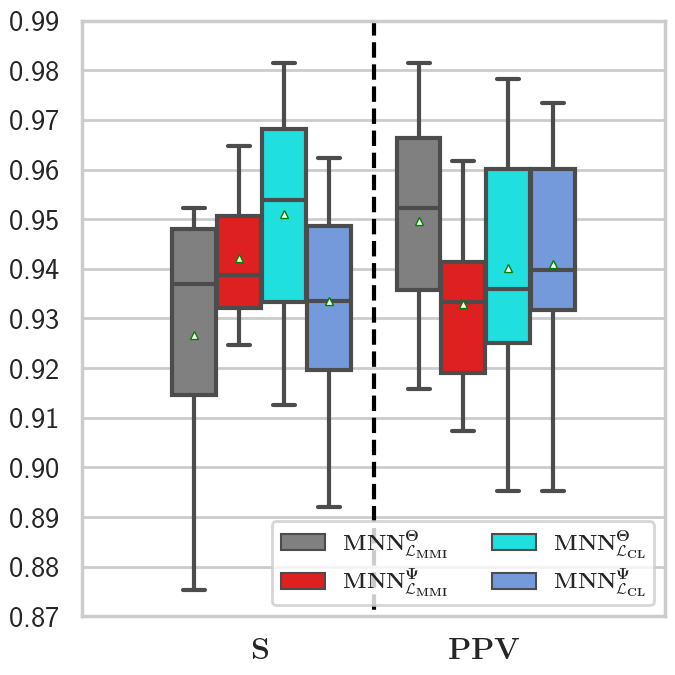

In [153]:
fig, ax2 = plt.subplots()
sns.set(rc={'figure.figsize':(7.27,7.27)})
sns.set_style("whitegrid")
sns.set_context("poster")
ax = sns.boxplot(x="metric", y="values",
            hue="model", palette=["gray", "red", "cyan", "cornflowerblue"],
            data=df_compare, showmeans=True,
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"green"},
                flierprops={"marker":"x","markerfacecolor":"orange", "markeredgecolor":"black"})

#adjust_box_widths(fig, 0.9)

ax.set_ylim(0.8664554122425808, 0.9832874609692444)


ax.set_yticks(np.arange(start=.8664554122425808, stop=.9932874609692444, step=.01))


ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.vlines([0.5], *ax.get_xlim(), linestyle='--', color='black')
ax.legend(fontsize=16, loc='lower center')
print(*ax.get_xlim(), *ax.get_ylim())
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
ax.set(xlabel=None)
ax.set(ylabel=None)

#sns.despine(left=True)


ax.legend(fontsize=16, ncol=2)
plt.tight_layout()
plt.savefig('boxplot_mnns_ph16.png', dpi=600, bbox_inches='tight')
plt.show()


In [130]:
ax = sns.boxplot(x="metric", y="values",
            hue="model", palette=["gray", "red", "cornflowerblue", "cyan"],
            data=df_compare, showmeans=True,
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"green"},
                flierprops={"marker":"x","markerfacecolor":"orange", "markeredgecolor":"black"})

print(ax.get_ylim())

(0.8664554122425808, 0.9832874609692444)


In [166]:
names = ['$\mathbf{HSMM}$',
         '$\mathbf{U}$-$\mathbf{Net}$',
         '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$']
_, ph16_hsmm_ppv, ph16_hsmm_sens = ph16_hsmm
df_ph16_sens = generate_boxplot_df('$\mathrm{\mathbf{S}}$', ph16_hsmm_sens,  ph16_crosse_unet_env[2], ph16_fernando_CE_mfcc[2], ph16_hmm_nnonly_cl_env[2], names=names)
df_ph16_ppv = generate_boxplot_df('$\mathrm{\mathbf{PPV}}$', ph16_hsmm_ppv, ph16_crosse_unet_env[1], ph16_fernando_CE_mfcc[1], ph16_hmm_nnonly_cl_env[1], names=names)
df_ph16 = pd.concat([df_ph16_sens, df_ph16_ppv], axis=0)


-0.8 1.8 0.8373709396983536 0.9946724358523028


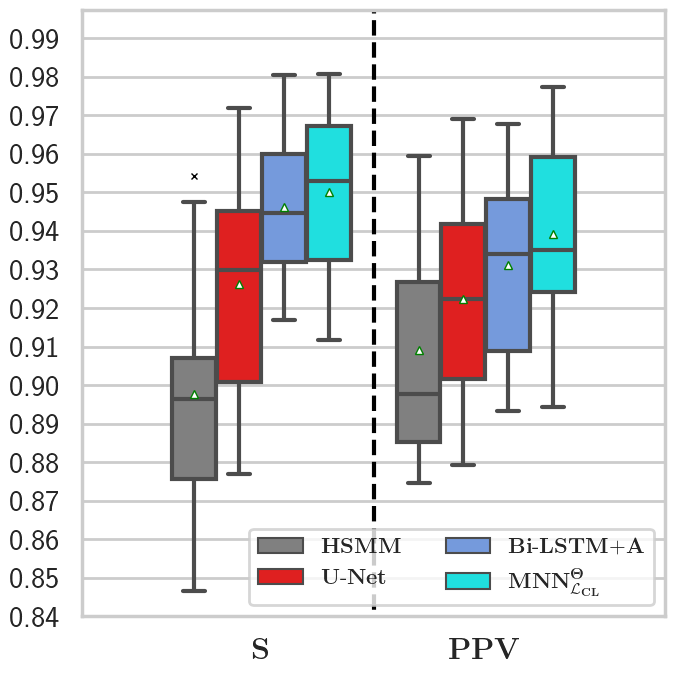

In [168]:
fig, ax2 = plt.subplots()
sns.set(rc={'figure.figsize':(7.27,7.27)})
sns.set_style("whitegrid")
sns.set_context("poster")
ax = sns.boxplot(x="metric", y="values",
            hue="model", palette=["gray", "red", "cornflowerblue", "cyan"],
            data=df_ph16, showmeans=True,
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"green"},
                flierprops={"marker":"x","markerfacecolor":"orange", "markeredgecolor":"black"})

#adjust_box_widths(fig, 0.9)

ax.set_ylim(0.8373709396983536, 0.9946724358523028)


ax.set_yticks(np.arange(start=.8373709396983536, stop=.9946724358523028, step=.01))


ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax.vlines([0.5], *ax.get_xlim(), linestyle='--', color='black')
ax.legend(fontsize=16, loc='lower center')
print(*ax.get_xlim(), *ax.get_ylim())
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
ax.set(xlabel=None)
ax.set(ylabel=None)

#sns.despine(left=True)


ax.legend(fontsize=16, ncol=2)
plt.tight_layout()
plt.savefig('boxplot_models_ph16.png', dpi=600, bbox_inches='tight')
plt.show()